In [39]:
import os

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

In [42]:
store_sales= pd.read_csv("Raw_data.csv")
store_sales.head(10)

,product_id,hosting,sale_date,revenue
0,Product 1,Cloud,2023-11-01,53583.85
1,Product 5,Cloud,2023-09-01,213436.30
2,Product 5,Cloud,2023-08-01,80083.97
3,Product 5,Data Center,2023-07-01,367722.25
4,Product 5,Cloud,2023-01-01,58483.99
5,Product 5,Data Center,2022-12-01,512291.83
6,Product 2,Data Center,2021-11-01,106808.57
7,Product 2,Cloud,2021-09-01,39958.91
8,Product 2,Data Center,2021-12-01,230751.05
9,Product 5,Data Center,2021-10-01,129712.05


Check null value

In [43]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  415 non-null    object 
 1   hosting     415 non-null    object 
 2   sale_date   415 non-null    object 
 3   revenue     415 non-null    float64
dtypes: float64(1), object(3)
memory usage: 13.1+ KB


Droping products and hosting colums

In [44]:
# Print column names
print(store_sales.columns)

# Print the first few rows of the DataFrame
print(store_sales.head())

Index(['product_id', 'hosting', 'sale_date', 'revenue'], dtype='object')
  product_id      hosting   sale_date    revenue
0  Product 1        Cloud  2023-11-01   53583.85
1  Product 5        Cloud  2023-09-01  213436.30
2  Product 5        Cloud  2023-08-01   80083.97
3  Product 5  Data Center  2023-07-01  367722.25
4  Product 5        Cloud  2023-01-01   58483.99


In [45]:
store_sales = store_sales.drop(['hosting', 'product_id'], axis=1)

In [46]:
#store_sales = store_sales.drop(['hosting', 'product_id'], axis=1)
#store_sales = store_sales[(store_sales['product_id'] == 'Product 1') & (store_sales['hosting'] == 'Cloud')]

# Display the resulting DataFrame
print(store_sales)

      sale_date    revenue
0    2023-11-01   53583.85
1    2023-09-01  213436.30
2    2023-08-01   80083.97
3    2023-07-01  367722.25
4    2023-01-01   58483.99
..          ...        ...
410  2019-07-01   15752.78
411  2023-10-01  172713.20
412  2023-11-01   37575.00
413  2019-12-01   73374.07
414  2021-04-01    7500.00

[415 rows x 2 columns]


In [47]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sale_date  415 non-null    object 
 1   revenue    415 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.6+ KB


Converting date

In [48]:
store_sales['date']= pd.to_datetime(store_sales['sale_date'])

In [49]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  415 non-null    object        
 1   revenue    415 non-null    float64       
 2   date       415 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.9+ KB


Converting data to a months period , and the sum the number of items in each month

In [50]:
monthly_sales = store_sales.groupby('date').sum().reset_index()


Convert The resulting date column to timestamp datatype

In [51]:
monthly_sales['date'] = pd.to_datetime(monthly_sales['date'])

In [52]:
monthly_sales.head(10)

,date,revenue
0,2017-01-01,9296.25
1,2017-02-01,14659.78
2,2017-03-01,16395.75
3,2017-04-01,22140.00
4,2017-05-01,29530.54
5,2017-06-01,28463.31
6,2017-07-01,36042.18
7,2017-08-01,47446.39
8,2017-09-01,57135.21
9,2017-10-01,44339.09


Visualization

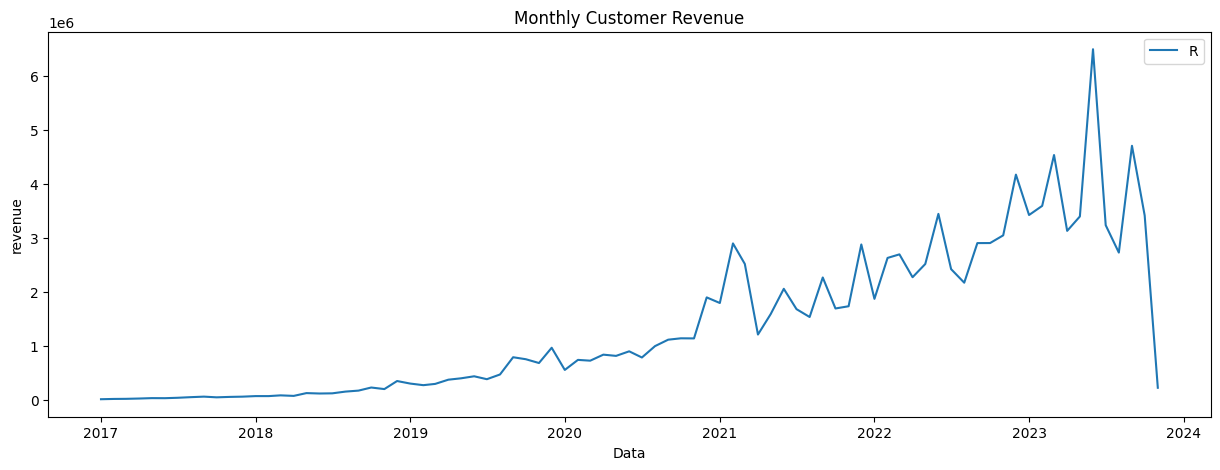

In [53]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['revenue'])
plt.xlabel("Data")
plt.ylabel('revenue')
plt.legend('Revenue')
plt.title('Monthly Customer Revenue')
plt.show()

Call the differenc on the sales columns to make the sales data stationary

In [54]:
monthly_sales['sales_diff']= monthly_sales['revenue'].diff()
monthly_sales= monthly_sales.dropna()
monthly_sales.tail(10)

,date,revenue,sales_diff
73,2023-02-01,3587870.03,169328.99
74,2023-03-01,4529161.48,941291.45
75,2023-04-01,3125277.50,-1403883.98
76,2023-05-01,3392057.29,266779.79
77,2023-06-01,6487162.24,3095104.95
78,2023-07-01,3229646.04,-3257516.20
79,2023-08-01,2723207.45,-506438.59
80,2023-09-01,4699592.65,1976385.20
81,2023-10-01,3409722.53,-1289870.12
82,2023-11-01,221323.65,-3188398.88


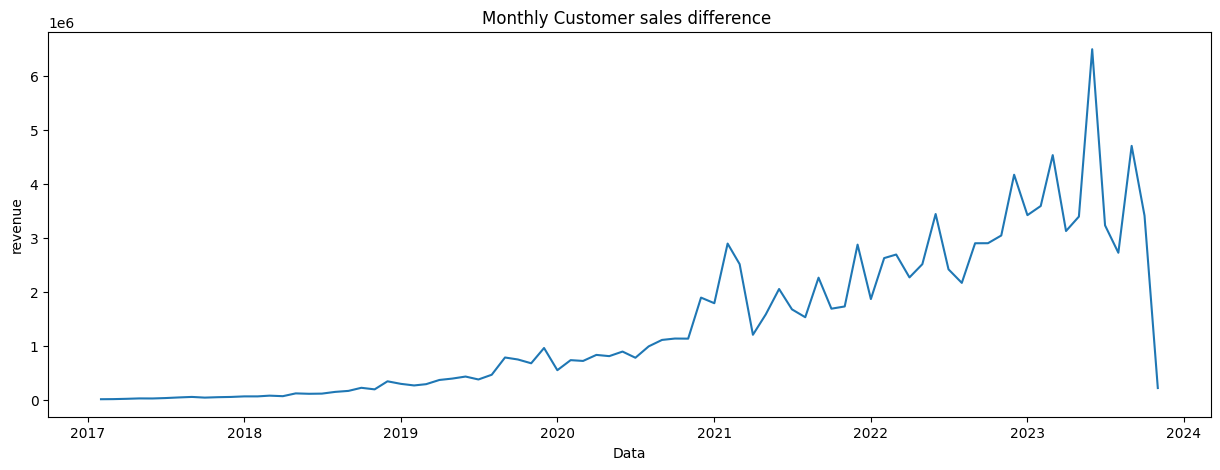

In [55]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['revenue'])
plt.xlabel("Data")
plt.ylabel('revenue')
plt.title('Monthly Customer sales difference ')
plt.show()

In [56]:
monthly_sales.shape

(82, 3)

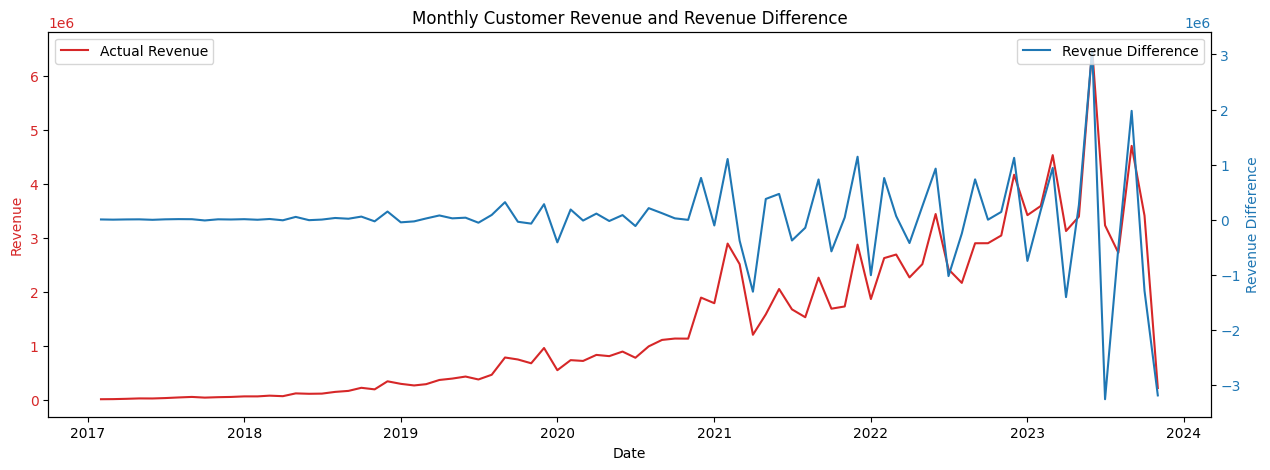

In [57]:
# Plot actual revenue
fig, ax1 = plt.subplots(figsize=(15, 5))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue', color=color)
ax1.plot(monthly_sales['date'], monthly_sales['revenue'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Actual Revenue'], loc='upper left')

# Create a secondary y-axis for the revenue differences
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Revenue Difference', color=color)
ax2.plot(monthly_sales['date'], monthly_sales['sales_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['Revenue Difference'], loc='upper right')

plt.title('Monthly Customer Revenue and Revenue Difference')
plt.show()

Droping sales and date

In [58]:
supervised_data= monthly_sales.drop(['date','revenue'], axis=1)

Preparing the supervise data

In [59]:
for i in range(1,13):
  col_name = 'month_'+str(i)
  supervised_data[col_name]= supervised_data['sales_diff'].shift(i)
supervised_data= supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87,-1067.23,7390.54,5744.25,1735.97,5363.53
1,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87,-1067.23,7390.54,5744.25,1735.97
2,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87,-1067.23,7390.54,5744.25
3,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87,-1067.23,7390.54
4,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87,-1067.23
5,3122.68,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21,7578.87
6,32079.93,3122.68,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82,11404.21
7,18401.84,32079.93,3122.68,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12,9688.82
8,57225.27,18401.84,32079.93,3122.68,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87,-12796.12
9,-28890.38,57225.27,18401.84,32079.93,3122.68,-7494.14,51704.96,-9871.00,13664.51,-44.13,10284.35,4542.62,7958.87


Train test

In [60]:
train_data= supervised_data[:-12]
test_data= supervised_data[-12:]
print(train_data.shape)
print(test_data.shape)

(58, 13)
(12, 13)


In [61]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [62]:
X_train, y_train = train_data[:,1:],train_data[:,0:1]
X_test, y_test = test_data[:,1:],test_data[:,0:1]
y_train= y_train.ravel()
y_test= y_test.ravel()
print('X_train shape',X_train.shape)
print('y_train shape',y_train.shape)
print('X_test shape',X_test.shape)
print('y_test shape',y_test.shape)

X_train shape (58, 12)
y_train shape (58,)
X_test shape (12, 12)
y_test shape (12,)


Make prediction data frame to merge the predeiceted sales prices of all train algo

In [63]:
sales_dates= monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [64]:
act_sales = monthly_sales['revenue'][-12:].to_list()
print(act_sales)

[4166050.87, 3418541.04, 3587870.0300000003, 4529161.48, 3125277.5, 3392057.29, 6487162.24, 3229646.04, 2723207.4499999997, 4699592.65, 3409722.53, 221323.65]


Create Linear regression model and prediction

In [65]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)

In [66]:
lr_pred = lr_pred.reshape(-1,1)
#this is a set matrix - contain the input features of the test data, and also the predictd output
lr_pred_test_set = np.concatenate([lr_pred, X_test], axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [67]:
result_list = []
for pred, actual in zip(lr_pred_test_set, act_sales):
    result_list.append(pred[0] + actual)

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)
print(predict_df)

         date  Linear Prediction
0  2022-12-01       5.013366e+06
1  2023-01-01       2.168159e+06
2  2023-02-01       3.606398e+06
3  2023-03-01       5.006600e+06
4  2023-04-01       2.520618e+06
5  2023-05-01       3.334426e+06
6  2023-06-01       7.438446e+06
7  2023-07-01       1.514111e+06
8  2023-08-01       2.565317e+06
9  2023-09-01       6.227423e+06
10 2023-10-01       2.988288e+06
11 2023-11-01       5.930913e+04


In [68]:
from sklearn.metrics import r2_score

# predict_df['Linear Prediction'] and monthly_sales['revenue'][-12:] are true and predicted values
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:]))
lr_mae = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:])
mse = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:])
rmse = np.sqrt(mse / len(monthly_sales['revenue'][-12:]))
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:])

print("mse", lr_mse)
print("mae", lr_mae)
print(f'RMSE: {rmse}')
print("r2", lr_r2)


mse 879852.040434071
mae 774139613055.9982
RMSE: 253991.40619582622
r2 0.8031152324289038


In [69]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:])
rmse = np.sqrt(mse / len(monthly_sales['revenue'][-12:]))
mae = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:], squared=False)
r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['revenue'][-12:])

# Calculate percentage values
max_revenue = monthly_sales['revenue'][-12:].max()

percentage_mse = (lr_mse / max_revenue) * 100
percentage_mae = (lr_mae / max_revenue) * 100
percentage_rmse = (rmse / max_revenue) * 100

print("MSE (Percentage): {:.2f}%".format(percentage_mse))
print("MAE (Percentage): {:.2f}%".format(percentage_mae))
print("RMSE (Percentage): {:.2f}%".format(percentage_rmse))
print("R2: {:.2%}".format(lr_r2))

MSE (Percentage): 13.56%
MAE (Percentage): 11933409.16%
RMSE (Percentage): 3.92%
R2: 80.31%


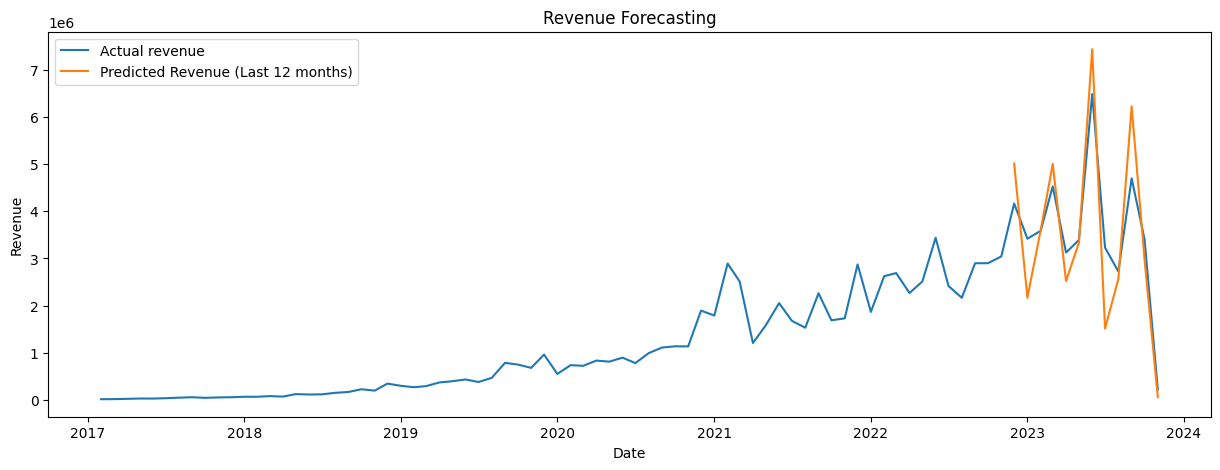

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['revenue'], label='Actual revenue')
plt.plot(monthly_sales['date'].tail(12), predict_df['Linear Prediction'], label='Predicted Revenue (Last 12 months)')
plt.xlabel("Date")
plt.ylabel('Revenue')
plt.title('Revenue Forecasting')
plt.legend()
plt.show()

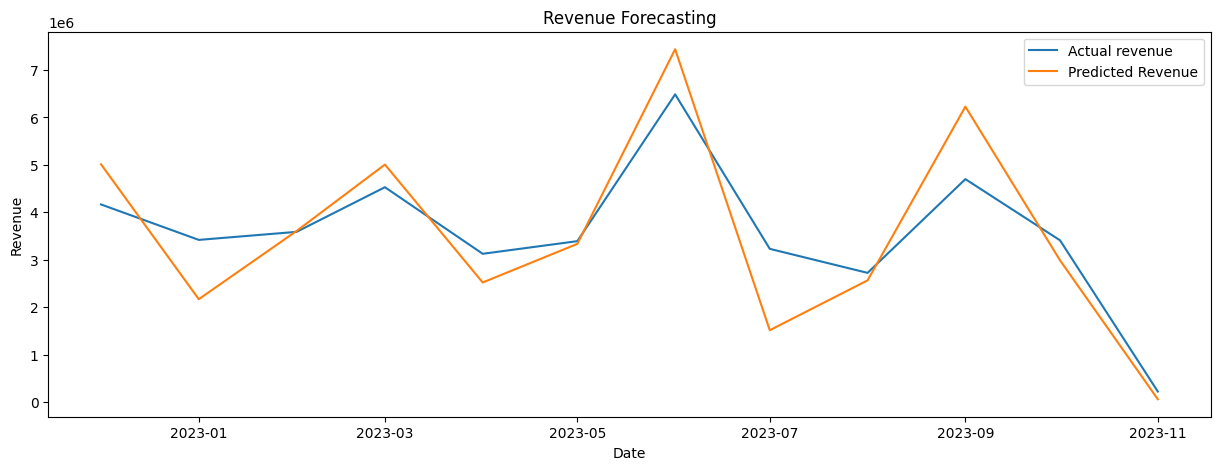

In [71]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'].tail(12), monthly_sales['revenue'].tail(12))
plt.plot(monthly_sales['date'].tail(12), predict_df['Linear Prediction'])
plt.xlabel("Date")
plt.ylabel('Revenue')
plt.title('Revenue Forecasting')
plt.legend(['Actual revenue', 'Predicted Revenue'])
plt.show()

In [72]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_data[:, 1:], train_data[:, 0:1], test_size=0.2, random_state=42)